### Udacity course Final Project 
#### Predict persons of interest using the Enron Dataset

#### This workflow does not include strategies to deal with imbalanced class prportions during model fitting. 

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline
import scipy as sp
import statsmodels.stats.multitest as smm
import csv
import gzip
import os
import scipy.io


#### Functions to convert dictionary to sklearn feature and target inputs

In [2]:
""" 
    A general tool for converting data from the
    dictionary format to an (n x k) python list that's 
    ready for training an sklearn algorithm

    n--no. of key-value pairs in dictonary
    k--no. of features being extracted

    dictionary keys are names of persons in dataset
    dictionary values are dictionaries, where each
        key-value pair in the dict is the name
        of a feature, and its value for that person

    In addition to converting a dictionary to a numpy 
    array, you may want to separate the labels from the
    features--this is what targetFeatureSplit is for

    so, if you want to have the poi label as the target,
    and the features you want to use are the person's
    salary and bonus, here's what you would do:

    feature_list = ["poi", "salary", "bonus"] 
    data_array = featureFormat( data_dictionary, feature_list )
    label, features = targetFeatureSplit(data_array)

    the line above (targetFeatureSplit) assumes that the
    label is the _first_ item in feature_list--very important
    that poi is listed first!
"""


import numpy as np

def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print("error: key ", feature, " not present")
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)

        return targets and features as separate lists

        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features


#### Load the data

In [306]:
import pickle

class StrToBytes:
    def __init__(self, fileobj):
        self.fileobj = fileobj
    def read(self, size):
        return self.fileobj.read(size).encode()
    def readline(self, size=-1):
        return self.fileobj.readline(size).encode()
    
path = "/Users/naiyan/desktop/UD/ud120-projects-master/final_project/"
file = path + "final_project_dataset.pkl"

### Load the dictionary containing the dataset
with open(file, "r") as f:
    data_dict = pickle.load(StrToBytes(f))

print('No of persons:', len(data_dict))

No of persons: 146


#### Explore the features

In [4]:
# Total salary = salary + bonus + expenses + other + deferred_income
# Total stock = exercised_stock_options + restricted_stock

#data_dict[list(data_dict.keys())[0]]
data_dict['ALLEN PHILLIP K']

{'salary': 201955,
 'to_messages': 2902,
 'deferral_payments': 2869717,
 'total_payments': 4484442,
 'loan_advances': 'NaN',
 'bonus': 4175000,
 'email_address': 'phillip.allen@enron.com',
 'restricted_stock_deferred': -126027,
 'deferred_income': -3081055,
 'total_stock_value': 1729541,
 'expenses': 13868,
 'from_poi_to_this_person': 47,
 'exercised_stock_options': 1729541,
 'from_messages': 2195,
 'other': 152,
 'from_this_person_to_poi': 65,
 'poi': False,
 'long_term_incentive': 304805,
 'shared_receipt_with_poi': 1407,
 'restricted_stock': 126027,
 'director_fees': 'NaN'}

#### Feature_Engineering
#### Normalize the features: 'from_poi_to_this_person' and 'from_this_person_to_poi' by 'to_messages' and 'from_messages' respectively to create new features 'normalized_from_poi_to_this_person' and 'normalized_from_this_person_to_poi'

In [5]:
### Task 3: Create new feature(s)

# Normalize 'from_poi_to_this_person' and 'from_this_person_to_poi' 
# by 'from_messages' and 'to_messages'


for i in list(data_dict.keys()):
    
    data_dict[i].update( {'normalized_from_poi_to_this_person' : 0, 'normalized_from_this_person_to_poi':0} )
    
    if data_dict[i]['from_poi_to_this_person']!= 'NaN' and data_dict[i]['to_messages']!= 'NaN':
        data_dict[i]['normalized_from_poi_to_this_person'] = data_dict[i]['from_poi_to_this_person']/data_dict[i]['to_messages']
        
    else:
        data_dict[i]['normalized_from_poi_to_this_person'] = 'NaN'
        
    
    if data_dict[i]['from_this_person_to_poi']!= 'NaN' and data_dict[i]['from_messages']!= 'NaN':
        data_dict[i]['normalized_from_this_person_to_poi'] = data_dict[i]['from_this_person_to_poi']/data_dict[i]['from_messages']
    
    else:
        data_dict[i]['normalized_from_this_person_to_poi'] = 'NaN'
        

#### Explore dataset and features

In [6]:
my_dataset = data_dict
# Use all features
features_to_use = list(data_dict[list(data_dict.keys())[0]].keys())
features_to_use.remove('poi')
features_list = ['poi']+ features_to_use
# Email address is removed as it is not a useful feature
features_list.remove('email_address')
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
print(len(labels),len(features), len(features[0]))


145 145 21


In [7]:
def scatterplot_2_features(A_label = 'total_payments', B_label = 'total_stock_value', limit_axis = False, xlim = [0,1.5E7] , ylim = [0,2.5E7]):
    A = []
    B = []
    A_label = A_label 
    B_label = B_label


    for i in range(len(labels)):
        A.append(features[i][features_list.index(A_label)-1])
        B.append(features[i][features_list.index(B_label)-1])

    plt.subplots(figsize=(15,15))
    plt.scatter(A, B, c = labels, cmap=plt.cm.get_cmap("prism", 2))
    plt.grid(b=None)
    
    if limit_axis:
        plt.xlim(xlim)
        plt.ylim(ylim)
        
    plt.xlabel(A_label, fontsize=20)
    plt.ylabel(B_label, fontsize=20)
    theta = np.linspace(0,1,2)
    cbar = plt.colorbar(ticks=theta, fraction=0.03, pad=0.04, aspect=10)

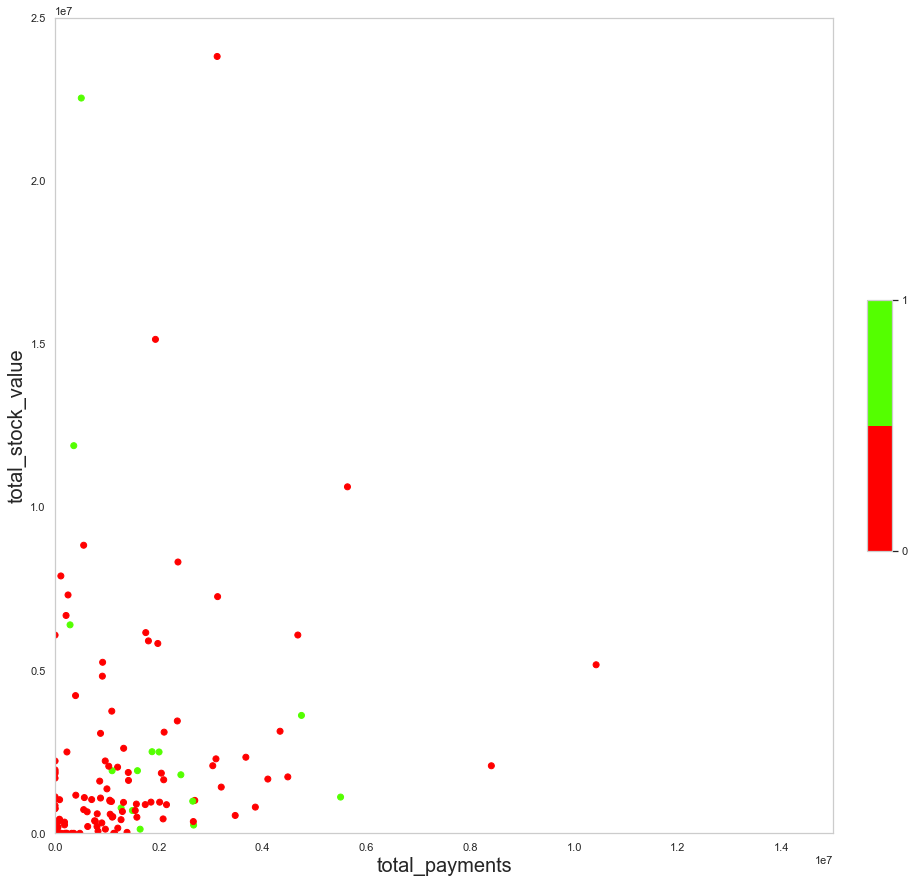

In [8]:
scatterplot_2_features(A_label = 'total_payments', B_label = 'total_stock_value', limit_axis = True, xlim = [0,1.5E7] , ylim = [0,2.5E7])

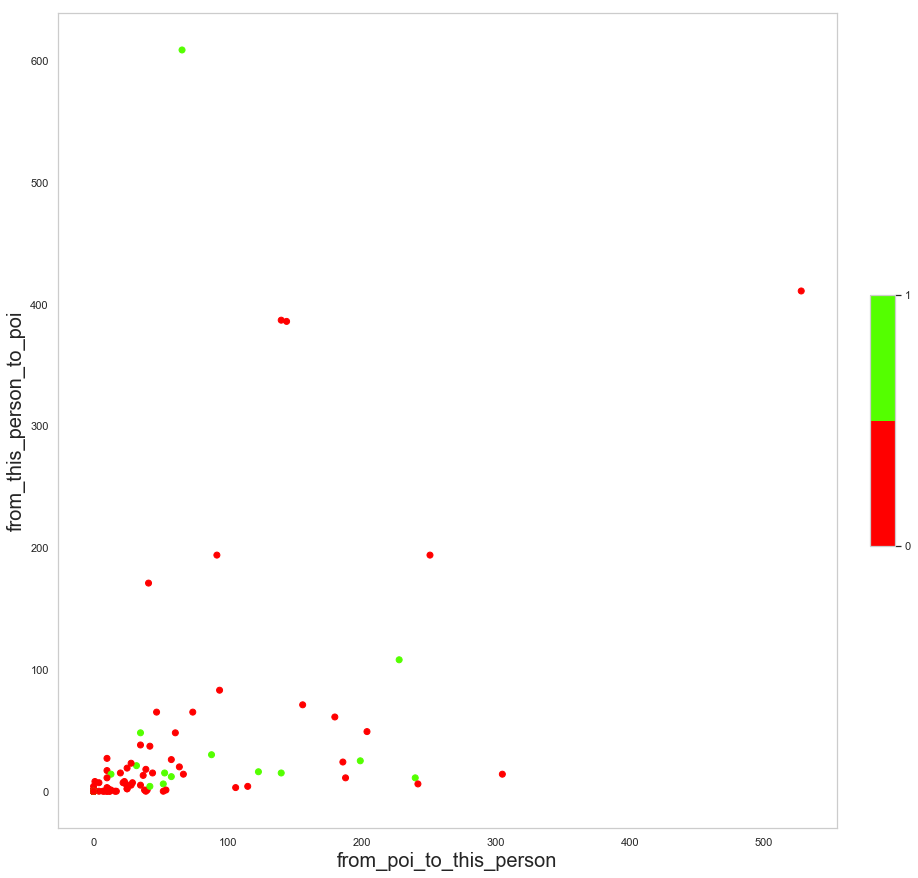

In [9]:
scatterplot_2_features(A_label = 'from_poi_to_this_person', B_label = 'from_this_person_to_poi')

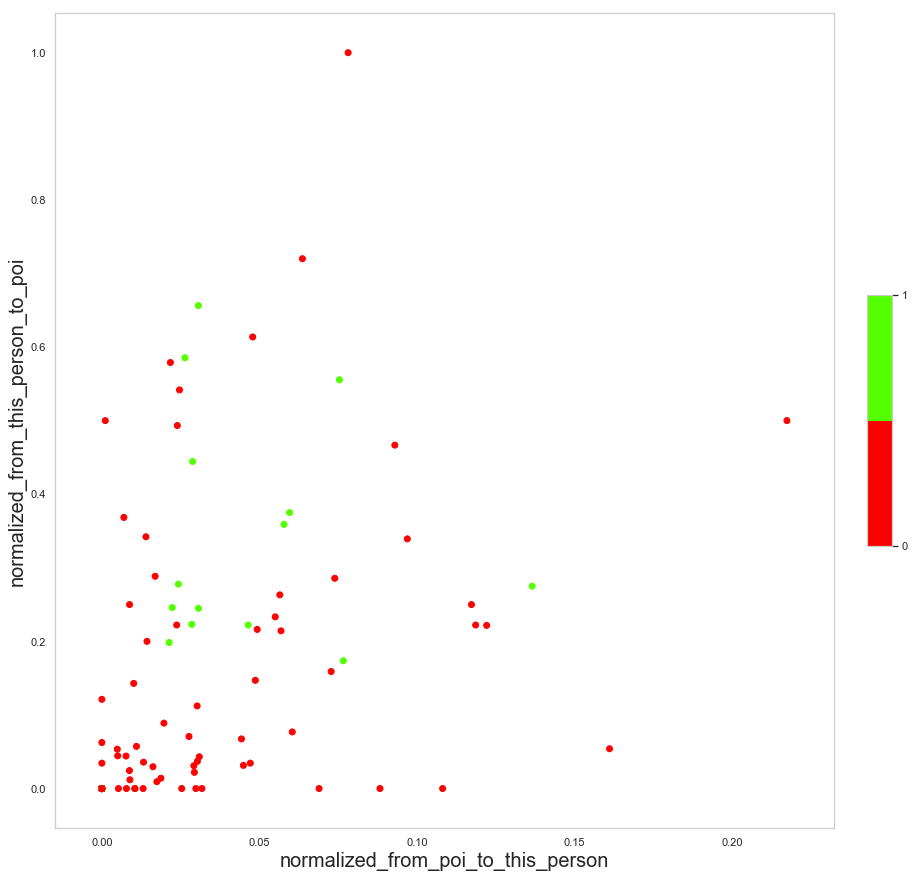

In [10]:
scatterplot_2_features(A_label = 'normalized_from_poi_to_this_person', B_label = 'normalized_from_this_person_to_poi')

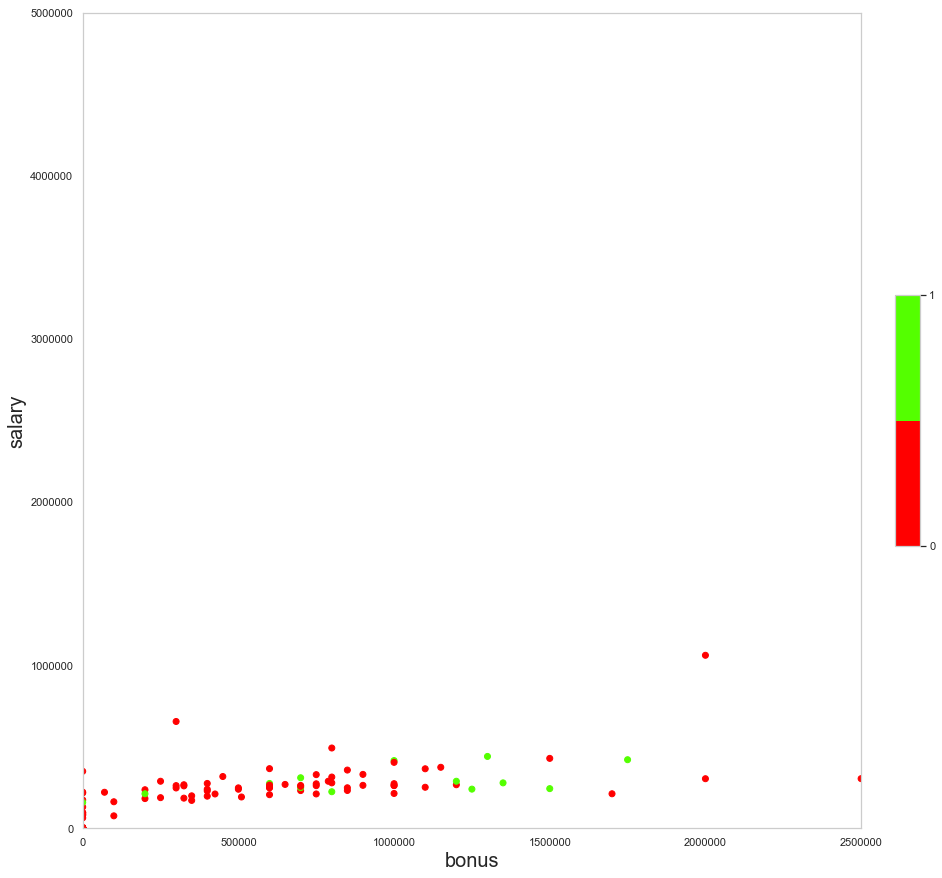

In [11]:
# Bonus may be a good feature
scatterplot_2_features(A_label = 'bonus', B_label = 'salary', limit_axis = True, xlim = [0,0.25E7] , ylim = [0,0.5E7])

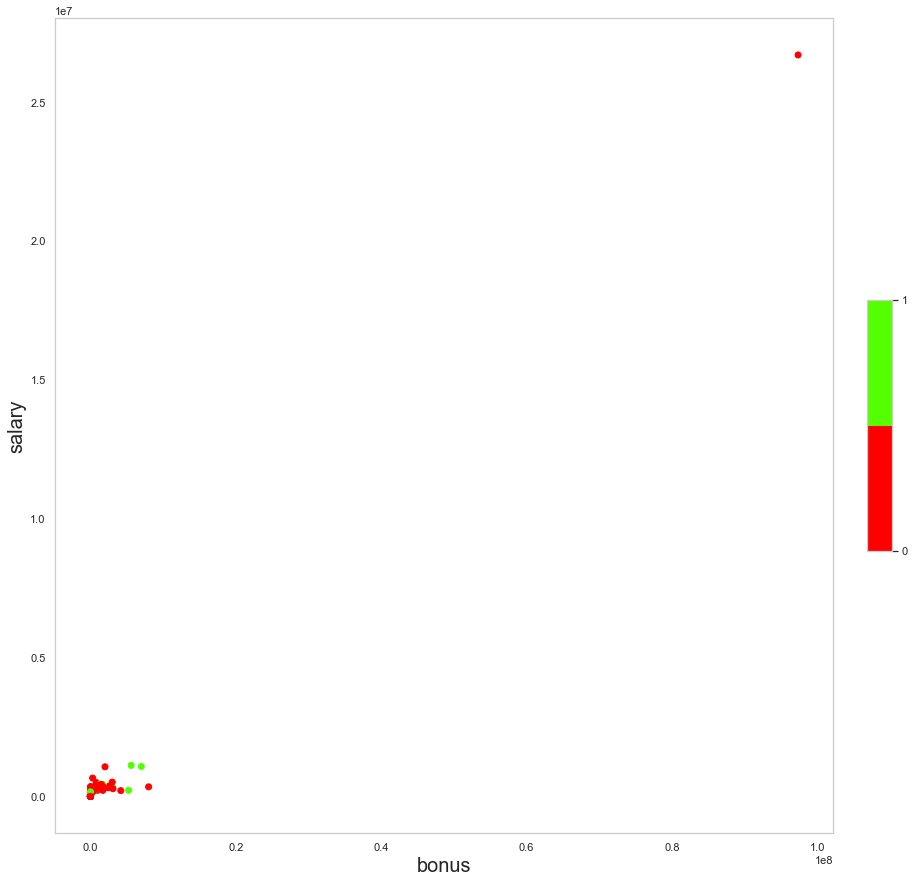

In [12]:
scatterplot_2_features(A_label = 'bonus', B_label = 'salary')

In [13]:
for name, value in data_dict.items():
    if float(data_dict[name]['salary'])>2.5E7 and float(data_dict[name]['bonus'])>0.8E8:
        print(name, value)

TOTAL {'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'loan_advances': 83925000, 'bonus': 97343619, 'email_address': 'NaN', 'restricted_stock_deferred': -7576788, 'deferred_income': -27992891, 'total_stock_value': 434509511, 'expenses': 5235198, 'from_poi_to_this_person': 'NaN', 'exercised_stock_options': 311764000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'long_term_incentive': 48521928, 'shared_receipt_with_poi': 'NaN', 'restricted_stock': 130322299, 'director_fees': 1398517, 'normalized_from_poi_to_this_person': 'NaN', 'normalized_from_this_person_to_poi': 'NaN'}


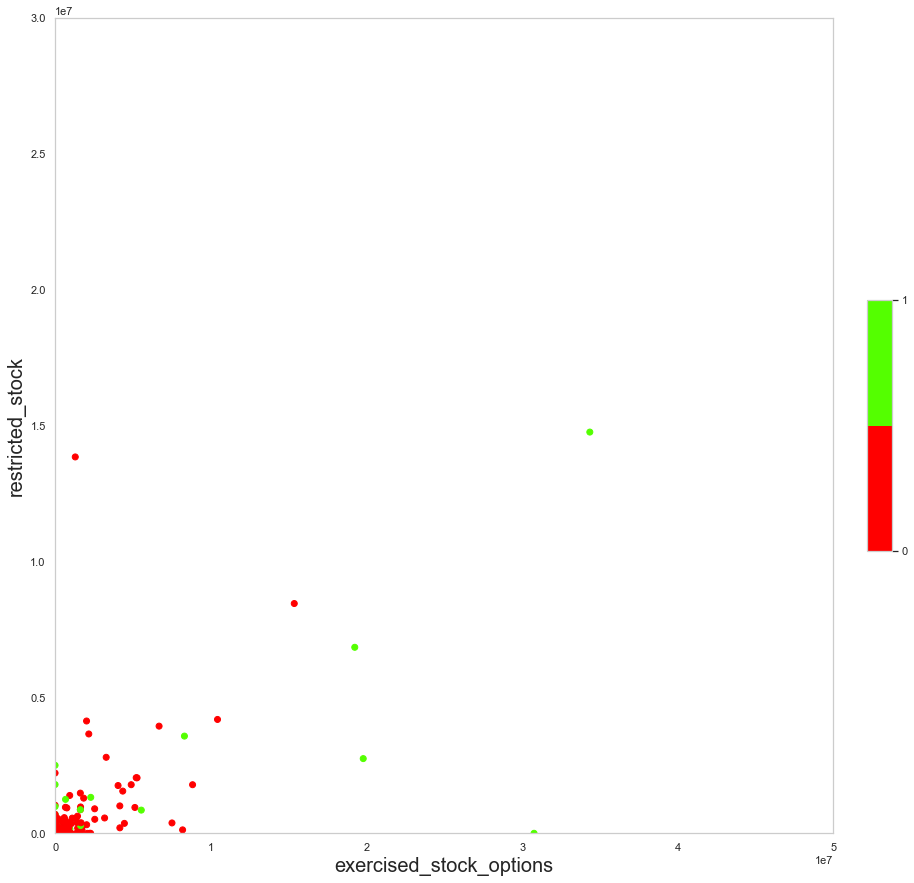

In [14]:
scatterplot_2_features(A_label = 'exercised_stock_options', B_label = 'restricted_stock', limit_axis = True, xlim = [0,0.5E8] , ylim = [0,0.3E8])

#### Feature selection I : AB testing between POI and not POI to select features that show promise to help discrimination between POI and not POI

In [15]:
from scipy import stats

Good_features_AB_Testing = []

for j in range(len(features[0])):
    
    POI = []
    Not_POI = []
    
    for i in range(len(labels)):
      
        if labels[i] == 1:
            POI.append(features[i][j])
        else:
            Not_POI.append(features[i][j])

    H, pval = stats.kruskal(POI, Not_POI)
    
    # With Bonferroni correction
    print(features_list[1+j], pval*len(features[0]))
    
    if pval*len(features[0])<0.15:
        Good_features_AB_Testing.append(features_list[1+j])
  
print('')
print(Good_features_AB_Testing)
print(len(Good_features_AB_Testing))


salary 0.01136492001870076
to_messages 0.2877702634686849
deferral_payments 20.806942726324834
total_payments 0.07988788442835772
loan_advances 9.119051622303687
bonus 0.0007377345613928173
restricted_stock_deferred 3.9306607206017103
deferred_income 0.10022573038756154
total_stock_value 0.0586871929414016
expenses 0.013770272952918884
from_poi_to_this_person 0.026312824482695705
exercised_stock_options 3.9129431407934954
from_messages 1.794212154355375
other 0.006280261112612123
from_this_person_to_poi 0.030944590206327012
long_term_incentive 0.19574250743913163
shared_receipt_with_poi 0.09364497738466573
restricted_stock 0.03968100872875654
director_fees 2.1117043097394697
normalized_from_poi_to_this_person 0.10051721466522891
normalized_from_this_person_to_poi 0.0017398004097784346

['salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'other', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'restricted_stock', 'no

#### Feature selection II : Based on reasoning

#### Remove 'from_poi_to_this_person' and 'shared_receipt_with_poi' and keep 'normalized_from_poi_to_this_person' and 'normalized_from_this_person_to_poi'.

#### Remove 'shared_receipt_with_poi' as it contains information about the label as explained in the lectures

#### Remove 'total_payments' as it is redudant and is an aggregate of other features including 'salary' , 'bonus' , 'expenses' , 'other' and 'deferred_income'

In [16]:
Good_features_AB_Testing.remove('from_poi_to_this_person')
Good_features_AB_Testing.remove('from_this_person_to_poi')
Good_features_AB_Testing.remove('shared_receipt_with_poi')

In [17]:
# Total payments = salary + bonus + expenses + other + deferred_income
# Total stock = exercised_stock_options + restricted_stock

Good_features_AB_Testing.remove('total_payments')

In [18]:
print(len(Good_features_AB_Testing))
Good_features_AB_Testing

9


['salary',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'other',
 'restricted_stock',
 'normalized_from_poi_to_this_person',
 'normalized_from_this_person_to_poi']

#### Explore the data - check for NaN and zeros

#### Note: The features with high number of NaN did not appear to help discrimination between POI and non-POI (see section: Feature selection I : AB testing between POI and not POI to select features that show promise to help discrimination between POI and not POI)

In [19]:
from collections import defaultdict

features_NaN_count_dict = defaultdict(int)
features_NaN_count_dict = features_NaN_count_dict.fromkeys(data_dict[list(data_dict.keys())[0]].keys(), 0)
features_zero_count_dict = defaultdict(int)
features_zero_count_dict = features_zero_count_dict.fromkeys(data_dict[list(data_dict.keys())[0]].keys(), 0)
features_NaN_or_zero_count_dict = defaultdict(int)
features_NaN_or_zero_count_dict = features_NaN_or_zero_count_dict.fromkeys(data_dict[list(data_dict.keys())[0]].keys(), 0)


for i in data_dict.keys():
    for j in data_dict[i].keys():
        if data_dict[i][j] == 'NaN':
            features_NaN_count_dict[j]+=1
            
for i in data_dict.keys():
    for j in data_dict[i].keys():
        if data_dict[i][j] == 0:
            features_zero_count_dict[j]+=1
                  
for i in data_dict.keys():
    for j in data_dict[i].keys():
        if data_dict[i][j] == 'NaN' or data_dict[i][j] == 0:
            features_NaN_or_zero_count_dict[j]+=1
                  

In [20]:
features_NaN_count_dict     

defaultdict(None,
            {'salary': 51,
             'to_messages': 60,
             'deferral_payments': 107,
             'total_payments': 21,
             'loan_advances': 142,
             'bonus': 64,
             'email_address': 35,
             'restricted_stock_deferred': 128,
             'deferred_income': 97,
             'total_stock_value': 20,
             'expenses': 51,
             'from_poi_to_this_person': 60,
             'exercised_stock_options': 44,
             'from_messages': 60,
             'other': 53,
             'from_this_person_to_poi': 60,
             'poi': 0,
             'long_term_incentive': 80,
             'shared_receipt_with_poi': 60,
             'restricted_stock': 36,
             'director_fees': 129,
             'normalized_from_poi_to_this_person': 60,
             'normalized_from_this_person_to_poi': 60})

In [21]:
features_zero_count_dict     

defaultdict(None,
            {'salary': 0,
             'to_messages': 0,
             'deferral_payments': 0,
             'total_payments': 0,
             'loan_advances': 0,
             'bonus': 0,
             'email_address': 0,
             'restricted_stock_deferred': 0,
             'deferred_income': 0,
             'total_stock_value': 0,
             'expenses': 0,
             'from_poi_to_this_person': 12,
             'exercised_stock_options': 0,
             'from_messages': 0,
             'other': 0,
             'from_this_person_to_poi': 20,
             'poi': 128,
             'long_term_incentive': 0,
             'shared_receipt_with_poi': 0,
             'restricted_stock': 0,
             'director_fees': 0,
             'normalized_from_poi_to_this_person': 12,
             'normalized_from_this_person_to_poi': 20})

In [22]:
features_NaN_or_zero_count_dict

defaultdict(None,
            {'salary': 51,
             'to_messages': 60,
             'deferral_payments': 107,
             'total_payments': 21,
             'loan_advances': 142,
             'bonus': 64,
             'email_address': 35,
             'restricted_stock_deferred': 128,
             'deferred_income': 97,
             'total_stock_value': 20,
             'expenses': 51,
             'from_poi_to_this_person': 72,
             'exercised_stock_options': 44,
             'from_messages': 60,
             'other': 53,
             'from_this_person_to_poi': 80,
             'poi': 128,
             'long_term_incentive': 80,
             'shared_receipt_with_poi': 60,
             'restricted_stock': 36,
             'director_fees': 129,
             'normalized_from_poi_to_this_person': 72,
             'normalized_from_this_person_to_poi': 80})

#### Feed Selected features into given functions 'featureFormat' and 'targetFeatureSplit' to produce labels and features to feed into classifier

In [23]:
Good_features_AB_Testing

['salary',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'other',
 'restricted_stock',
 'normalized_from_poi_to_this_person',
 'normalized_from_this_person_to_poi']

#### Remove outlier 'TOTAL' from data_dict

In [24]:
# Removing this outlier greatly improves F1 score
data_dict.pop('TOTAL')

{'salary': 26704229,
 'to_messages': 'NaN',
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 'NaN',
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 311764000,
 'from_messages': 'NaN',
 'other': 42667589,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 130322299,
 'director_fees': 1398517,
 'normalized_from_poi_to_this_person': 'NaN',
 'normalized_from_this_person_to_poi': 'NaN'}

In [25]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi']+ Good_features_AB_Testing
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#### Check if dataset has unequal class proportions

#### This dataset indeed has unequal class proportions

In [26]:
from collections import Counter
Counter(labels)

Counter({0.0: 125, 1.0: 18})

#### Feature scaling

In [27]:
from sklearn.preprocessing import StandardScaler

# n_samples x n_features
print('Number of samples:', np.array(features).shape[0])
print('Number of features:', np.array(features).shape[1])
print('')

X_std = StandardScaler().fit_transform(features)

print('Number of samples:', np.array(X_std).shape[0])
print('Number of features:', np.array(X_std).shape[1])


Number of samples: 143
Number of features: 9

Number of samples: 143
Number of features: 9


#### Classification: Algorithm Selection using Nested Cross Validation

In [28]:
"""

Algorithm selection with nested cross validation

Implement: 
(1) Standard scaling on dataset
(2) With and Without PCA
(3) Nested cross validation for algorithm selection
(4) Stratified K fold cross validation for dataset with imbalanced classes
(5) GridSearch to iterate through range of parameters for PCA and classifier

Arguments:

Num_Random_Trials: Number of random trials to iterate through outer and inner CV
Num_of_folds_outer: Number of folds in outer loop of nested CV
Num_of_folds_inner: Number of folds in inner loop of nested CV
Scoring_metric: Performance evaluation metric for algorithm selection

"""

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, cross_val_score
import time 
import warnings

def entire_pipeline(classifier = LogisticRegression(), parameters = [], Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'f1', warning_true = True):

        
    if warning_true:
        warnings.filterwarnings('ignore')

    pipe = Pipeline([['sc', StandardScaler()], 
                     ['pca', PCA()], 
                     ['clf', classifier]
                    ])

    # To store the scores from each fold of the outer loop 
    scores = []

    start = time.time()

    for i in range(Num_Random_Trials):

    #     inner_cv = KFold(n_splits=Num_of_folds_inner,shuffle=True,random_state=i)
    #     outer_cv = KFold(n_splits=Num_of_folds_outer,shuffle=True,random_state=i)

        inner_cv = StratifiedKFold(n_splits=Num_of_folds_inner,shuffle=True,random_state=i)
        outer_cv = StratifiedKFold(n_splits=Num_of_folds_outer,shuffle=True,random_state=i)

        gs = GridSearchCV(estimator=pipe,param_grid=parameters,
                          cv=inner_cv,scoring=Scoring_metric, n_jobs=-1)

        nested_scores = cross_val_score(gs, X=features, y=labels, cv=outer_cv, scoring=Scoring_metric)
        scores.append(np.mean(nested_scores))

    print('Averaged_' + str(Scoring_metric) + '_score: %.3f +/-%0.3f' %(np.mean(scores), np.std(scores)))
    print('Time_of_completion:', time.time()-start)


#### (1) Logistic Regression

In [29]:
# Note: Option for no dimensional reduction is included
# Note: class_weight in classifier already set to balanced by default
n_all_PCA_components = min(np.array(features).shape[0], np.array(features).shape[1])
    
parameters = [{'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__C': 10.0**np.arange(-4,4),
               'clf__penalty': ['l1','l2'],
               'clf__max_iter': [200]},
              
              {'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__penalty': ['none'],
               'clf__solver': ['saga'],
               'clf__max_iter': [200]}]
    
entire_pipeline(classifier = LogisticRegression(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'f1',warning_true = True)
entire_pipeline(classifier = LogisticRegression(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'precision',warning_true = True)
entire_pipeline(classifier = LogisticRegression(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'recall',warning_true = True)
entire_pipeline(classifier = LogisticRegression(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'accuracy',warning_true = True)

Averaged_f1_score: 0.319 +/-0.038
Time_of_completion: 42.964569091796875
Averaged_precision_score: 0.391 +/-0.133
Time_of_completion: 44.82913613319397
Averaged_recall_score: 0.327 +/-0.023
Time_of_completion: 56.593029737472534
Averaged_accuracy_score: 0.859 +/-0.010
Time_of_completion: 51.30131411552429


#### (2) Random forest

In [40]:
n_all_PCA_components = min(np.array(features).shape[0], np.array(features).shape[1])
    
parameters = [{'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__n_estimators': [10,30,100],
               'clf__max_depth': np.arange(2,5)
              },
              
              {'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__n_estimators': [10,30,100],
               'clf__max_depth': np.arange(2,5)
              }]
    
entire_pipeline(classifier = RandomForestClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'f1',warning_true = True)
entire_pipeline(classifier = RandomForestClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'precision',warning_true = True)
entire_pipeline(classifier = RandomForestClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'recall',warning_true = True)
entire_pipeline(classifier = RandomForestClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'accuracy',warning_true = True)

Averaged_f1_score: 0.191 +/-0.042
Time_of_completion: 497.48854780197144
Averaged_precision_score: 0.213 +/-0.091
Time_of_completion: 397.25740909576416
Averaged_recall_score: 0.130 +/-0.099
Time_of_completion: 397.59817481040955
Averaged_accuracy_score: 0.848 +/-0.012
Time_of_completion: 425.8592691421509


#### (3) Support vector machine

In [41]:
n_all_PCA_components = min(np.array(features).shape[0], np.array(features).shape[1])
    
parameters = [{'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__C': 10.0**np.arange(-4,4), 
               'clf__kernel': ['linear', 'poly','sigmoid'],
               'clf__kernel': ['linear']
              },
              
              {'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__C': 10.0**np.arange(-4,4),
               'clf__gamma': 10.0**np.arange(-4,4), 
               'clf__kernel': ['rbf']
               
              }]
    
entire_pipeline(classifier = svm.SVC(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'f1',warning_true = True)
entire_pipeline(classifier = svm.SVC(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'precision',warning_true = True)
entire_pipeline(classifier = svm.SVC(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'recall',warning_true = True)
entire_pipeline(classifier = svm.SVC(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'accuracy',warning_true = True)


Averaged_f1_score: 0.169 +/-0.062
Time_of_completion: 454.1742830276489
Averaged_precision_score: 0.223 +/-0.128
Time_of_completion: 459.2771236896515
Averaged_recall_score: 0.233 +/-0.068
Time_of_completion: 426.40403604507446
Averaged_accuracy_score: 0.852 +/-0.016
Time_of_completion: 472.82825803756714


#### (4) KNN

In [38]:
n_all_PCA_components = min(np.array(features).shape[0], np.array(features).shape[1])
    
parameters = [{'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__n_neighbors': np.arange(1,20)
              }]
    
entire_pipeline(classifier = KNeighborsClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'f1',warning_true = True)
entire_pipeline(classifier = KNeighborsClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'precision',warning_true = True)
entire_pipeline(classifier = KNeighborsClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'recall',warning_true = True)
entire_pipeline(classifier = KNeighborsClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'accuracy',warning_true = True)

Averaged_f1_score: 0.233 +/-0.105
Time_of_completion: 56.39637207984924
Averaged_precision_score: 0.214 +/-0.114
Time_of_completion: 55.539079904556274
Averaged_recall_score: 0.290 +/-0.083
Time_of_completion: 50.21831011772156
Averaged_accuracy_score: 0.839 +/-0.016
Time_of_completion: 57.45481610298157


#### (5) Adaboost

In [42]:
n_all_PCA_components = min(np.array(features).shape[0], np.array(features).shape[1])
    
parameters = [{'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__n_estimators': np.arange(1,11)*10
              }]
    
entire_pipeline(classifier = AdaBoostClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'f1',warning_true = True)
entire_pipeline(classifier = AdaBoostClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'precision',warning_true = True)
entire_pipeline(classifier = AdaBoostClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'recall',warning_true = True)
entire_pipeline(classifier = AdaBoostClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'accuracy',warning_true = True)

Averaged_f1_score: 0.234 +/-0.077
Time_of_completion: 319.9270250797272
Averaged_precision_score: 0.239 +/-0.135
Time_of_completion: 403.9665789604187
Averaged_recall_score: 0.240 +/-0.076
Time_of_completion: 324.12220287323
Averaged_accuracy_score: 0.818 +/-0.012
Time_of_completion: 292.44593572616577


#### (6) Gradient boosting

In [30]:
n_all_PCA_components = min(np.array(features).shape[0], np.array(features).shape[1])
    
parameters = [{'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__n_estimators': np.arange(1,11)*10,
               'clf__max_depth': np.arange(2,5)
              }]
    
entire_pipeline(classifier = GradientBoostingClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'f1',warning_true = True)
entire_pipeline(classifier = GradientBoostingClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'precision',warning_true = True)
entire_pipeline(classifier = GradientBoostingClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'recall',warning_true = True)
entire_pipeline(classifier = GradientBoostingClassifier(), parameters = parameters, Num_Random_Trials = 5,Num_of_folds_outer = 5, Num_of_folds_inner = 5, Scoring_metric = 'accuracy',warning_true = True)

Averaged_f1_score: 0.233 +/-0.098
Time_of_completion: 505.1528902053833
Averaged_precision_score: 0.245 +/-0.073
Time_of_completion: 469.5863721370697
Averaged_recall_score: 0.280 +/-0.053
Time_of_completion: 409.49022579193115
Averaged_accuracy_score: 0.849 +/-0.016
Time_of_completion: 365.01019310951233


#### Compare scores across all classifiers

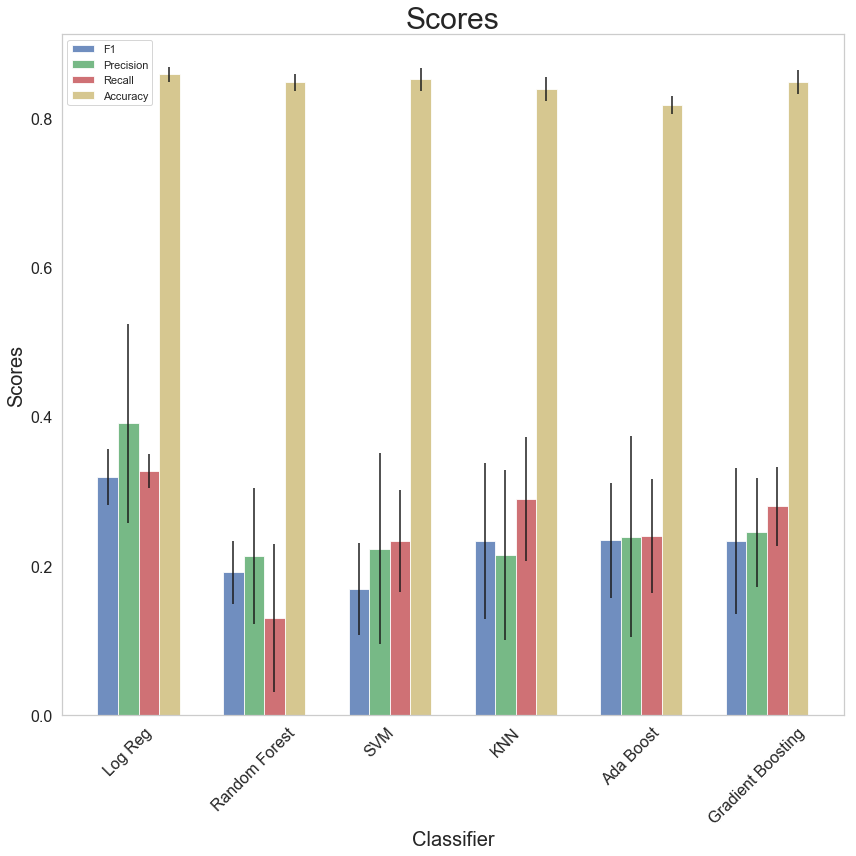

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 6

F1_scores = (0.319, 0.191, 0.169, 0.233, 0.234, 0.233)
F1_scores_error = (0.038, 0.042, 0.062,0.105, 0.077, 0.098)

Precision_scores = (0.391, 0.213, 0.223, 0.214, 0.239, 0.245)
Precision_scores_error = (0.133,0.091, 0.128, 0.114, 0.135, 0.073)

Recall_scores = (0.327, 0.130,0.233, 0.290, 0.240, 0.280 )
Recall_scores_error = (0.023, 0.099, 0.068, 0.083, 0.076, 0.053 )

Accuracy_scores = (0.859, 0.848, 0.852, 0.839, 0.818, 0.849)
Accuracy_scores_error = (0.010, 0.012, 0.016, 0.016, 0.012, 0.016)    

space = (0)
             
# create plot
fig, ax = plt.subplots(figsize=(12,12))
index = np.arange(n_groups)

# Bar graphs expect a total width of "1.0" per group
# Thus, you should make the sum of the two margins
# plus the sum of the width for each entry equal 1.0.
# One way of doing that is shown below. You can make
# The margins smaller if they're still too big.

margin = 0.01
bar_width = (1.-2.*margin)/(6)
#bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, F1_scores, bar_width,alpha=opacity,color='b',label='F1',yerr=F1_scores_error)

rects2 = plt.bar(index + bar_width, Precision_scores, bar_width,alpha=opacity,color='g',label='Precision',yerr=Precision_scores_error)

rects3 = plt.bar(index + 2*bar_width, Recall_scores, bar_width,alpha=opacity,color='r',label='Recall',yerr=Recall_scores_error)

rects4 = plt.bar(index + 3*bar_width, Accuracy_scores, bar_width, alpha=opacity,color='y',label='Accuracy',yerr=Accuracy_scores_error)


plt.xlabel('Classifier', {'size': '20'})
plt.ylabel('Scores', {'size': '20'})

plt.title('Scores', {'size': '30'})
plt.xticks(index + bar_width, ('Log Reg', 'Random Forest', 'SVM', 'KNN', 'Ada Boost', 'Gradient Boosting'), fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.grid('off')
plt.legend()

plt.tight_layout()
plt.show()

#### Model selection/ Fine tuning the hyperparamters of the selected algorithm

#### Logistic regression is selected as it has the highest mean score for F1, Precision, Recall and Accuracy

In [108]:
"""

To fine tune model and perform validation

Implement: 
(1) Standard scaling on dataset
(2) With and Without PCA
(3) Logistic regression classifier
(4) Stratified K fold cross validation for dataset with imbalanced classes. Cross validation is to prevent overfitting the data and allow choosing paramters that can generalize across datasets (model tuning): can avoid if dataset is very big.
(5) GridSearch to iterate through range of parameters for PCA and classifier

Arguments:

Scoring_metric: Performance evaluation metric for algorithm selection

"""

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, cross_val_score
import time 
import warnings

def ModelFineTune(classifier = LogisticRegression(), parameters = [], Num_of_folds = 5, Repeats = 1000, Scoring_metric = 'f1', warning_true = True):

        
    if warning_true:
        warnings.filterwarnings('ignore')

    pipe = Pipeline([['sc', StandardScaler()], 
                     ['pca', PCA()], 
                     ['clf', classifier]
                    ])

    # To store the scores from each fold of the outer loop 
    scores_and_best_parameters = {'scores':[], 'parameters':[]}

    start = time.time()
    
    for i in np.arange(Repeats+1):
        
        k_fold = StratifiedKFold(n_splits=Num_of_folds,shuffle=True,random_state=i)

        gs = GridSearchCV(estimator=pipe,param_grid=parameters,cv=k_fold,scoring=Scoring_metric, n_jobs=-1)
        gs = gs.fit(features, labels)
        scores_and_best_parameters['scores'].append(gs.best_score_)
        scores_and_best_parameters['parameters'].append(str(gs.best_params_))
        
    print('Compute time:' , time.time() - start)

    return scores_and_best_parameters

In [ ]:
n_all_PCA_components = min(np.array(features).shape[0], np.array(features).shape[1])
    
parameters = [{'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__C': 10.0**np.arange(-4,4),
               'clf__penalty': ['l1','l2'],
               'clf__max_iter': [200]},
              
              {'pca__n_components': np.arange(1,n_all_PCA_components+1),
               'clf__penalty': ['none'],
               'clf__solver': ['saga'],
               'clf__max_iter': [200]}]
 
scores_and_best_parameters = ModelFineTune(classifier = LogisticRegression(), parameters = parameters, Num_of_folds = 5, Repeats = 200, Scoring_metric = 'f1', warning_true = True)

#### F1

In [134]:
scores_and_best_parameters = ModelFineTune(classifier = LogisticRegression(), parameters = parameters, Num_of_folds = 5, Repeats = 1000, Scoring_metric = 'f1', warning_true = True)

Compute time: 1858.38050198555


In [135]:
best_params_df = pd.DataFrame(scores_and_best_parameters)
best_params_df = best_params_df.groupby(['parameters'])['scores'].describe()
best_params_df = np.round(best_params_df,decimals=2).sort_values(by = ['count', 'mean'],axis=0,ascending=[False,False])
display(best_params_df.head(10))

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 2}",197.0,0.37,0.04,0.28,0.35,0.37,0.39,0.51
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 1}",90.0,0.36,0.04,0.27,0.33,0.35,0.38,0.46
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 4}",84.0,0.38,0.04,0.29,0.36,0.39,0.40,0.46
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 5}",76.0,0.38,0.04,0.32,0.35,0.37,0.40,0.50
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 6}",76.0,0.38,0.03,0.30,0.36,0.38,0.41,0.47
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 3}",69.0,0.38,0.05,0.28,0.34,0.38,0.41,0.50
"{'clf__C': 0.01, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 2}",65.0,0.35,0.03,0.27,0.33,0.35,0.37,0.44
"{'clf__C': 0.01, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 1}",56.0,0.34,0.02,0.27,0.33,0.34,0.36,0.38
"{'clf__C': 0.001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 1}",38.0,0.36,0.03,0.30,0.34,0.37,0.38,0.42


#### Precision

In [138]:
scores_and_best_parameters = ModelFineTune(classifier = LogisticRegression(), parameters = parameters, Num_of_folds = 5, Repeats = 1000, Scoring_metric = 'precision', warning_true = True)

Compute time: 2192.276240825653


In [141]:
best_params_df = pd.DataFrame(scores_and_best_parameters)
best_params_df = best_params_df.groupby(['parameters'])['scores'].describe()
best_params_df = np.round(best_params_df,decimals=2).sort_values(by = ['count', 'mean'],axis=0,ascending=[False,False])
display(best_params_df.head(10))

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
"{'clf__C': 0.01, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 1}",144.0,0.52,0.08,0.30,0.45,0.52,0.57,0.72
"{'clf__C': 0.01, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 2}",111.0,0.53,0.08,0.37,0.47,0.54,0.59,0.71
"{'clf__C': 0.1, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 2}",100.0,0.53,0.08,0.38,0.47,0.51,0.57,0.71
"{'clf__C': 0.1, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 1}",76.0,0.52,0.07,0.30,0.49,0.50,0.60,0.61
"{'clf__C': 1.0, 'clf__max_iter': 200, 'clf__penalty': 'l1', 'pca__n_components': 1}",40.0,0.51,0.06,0.40,0.50,0.50,0.51,0.61
"{'clf__C': 0.1, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 7}",36.0,0.53,0.09,0.34,0.47,0.51,0.58,0.73
"{'clf__C': 0.1, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 6}",30.0,0.57,0.08,0.41,0.50,0.55,0.63,0.71
"{'clf__C': 0.1, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 5}",28.0,0.54,0.08,0.40,0.50,0.54,0.60,0.70
"{'clf__C': 0.1, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 9}",25.0,0.54,0.08,0.41,0.50,0.54,0.57,0.70


#### Recall

In [137]:
scores_and_best_parameters = ModelFineTune(classifier = LogisticRegression(), parameters = parameters, Num_of_folds = 5, Repeats = 1000, Scoring_metric = 'recall', warning_true = True)

Compute time: 1811.3147070407867


In [132]:
best_params_df = np.round(best_params_df,decimals=2).sort_values(by = ['count', 'mean'],axis=0,ascending=[False,False])
display(best_params_df.head(10))

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 2}",370.0,0.39,0.05,0.30,0.35,0.38,0.41,0.59
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 1}",255.0,0.34,0.04,0.25,0.32,0.33,0.36,0.46
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 6}",97.0,0.40,0.04,0.30,0.38,0.40,0.43,0.51
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 4}",94.0,0.40,0.04,0.32,0.37,0.40,0.42,0.51
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 3}",80.0,0.40,0.05,0.30,0.37,0.40,0.43,0.51
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 5}",71.0,0.40,0.05,0.30,0.37,0.40,0.44,0.57
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 7}",28.0,0.41,0.04,0.35,0.38,0.41,0.44,0.49
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 8}",4.0,0.43,0.03,0.38,0.42,0.44,0.45,0.45
"{'clf__C': 0.0001, 'clf__max_iter': 200, 'clf__penalty': 'l2', 'pca__n_components': 9}",1.0,0.37,NaN,0.37,0.37,0.37,0.37,0.37


#### Validation curve to check over- and under-fitting

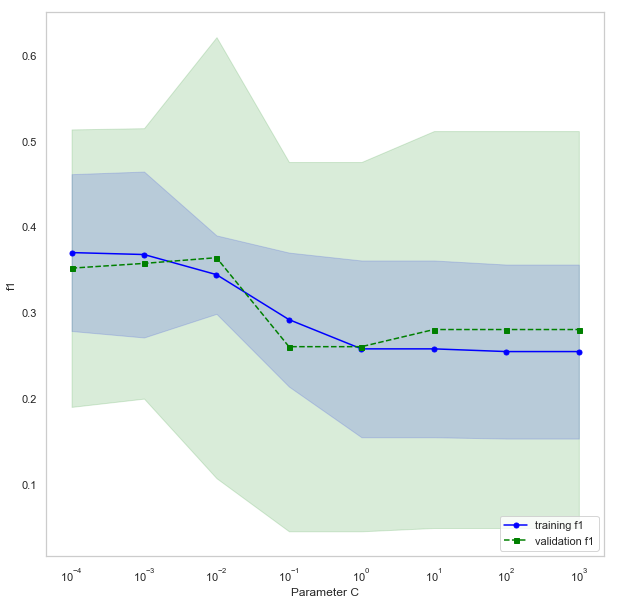

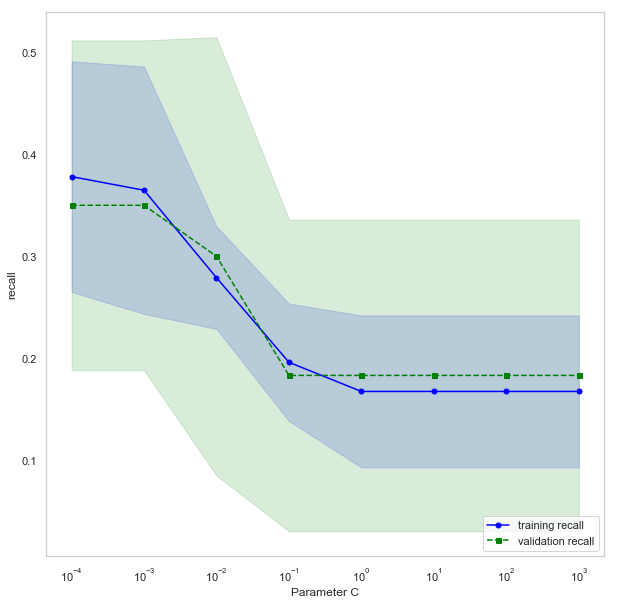

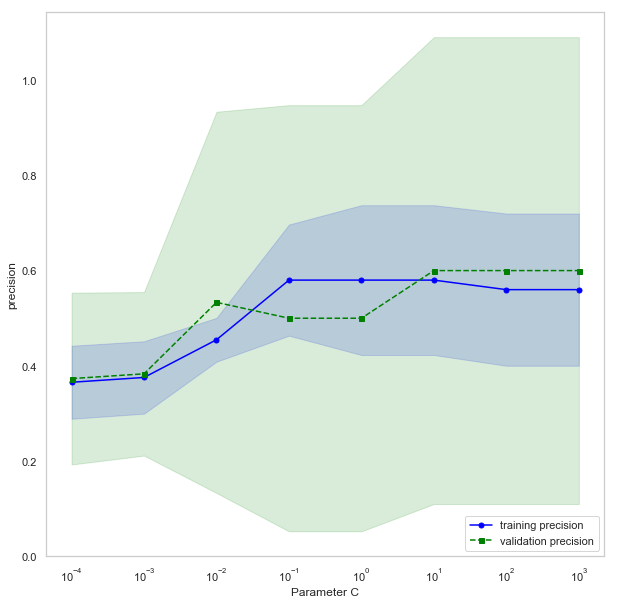

In [305]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve

def validation_curve_score_vs_C(scoring_metric='f1', name = 'f1'):

    Num_of_folds = 5

    param_range = 10.0**np.arange(-4,4)

    warnings.filterwarnings('ignore')

    pipe = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', max_iter=200))            


    k_fold = StratifiedKFold(n_splits=Num_of_folds,shuffle=True,random_state=1)
    train_scores, test_scores = validation_curve(estimator = pipe, X = features, y = labels , param_name='logisticregression__C', param_range = param_range, cv = k_fold, scoring = scoring_metric)

    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure(figsize=(10,10))
    plt.plot(param_range, train_mean,color='blue',marker='o',markersize=5, label='training' + ' ' + name)
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color ='blue')
    plt.plot(param_range, test_mean, color='green',linestyle='--',marker='s',markersize=5, label = 'validation' + ' ' + name)

    plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Parameter C')
    plt.ylabel(name)
    plt.show()

validation_curve_score_vs_C(scoring_metric='f1', name = 'f1')
validation_curve_score_vs_C(scoring_metric='recall', name = 'recall')
validation_curve_score_vs_C(scoring_metric='precision', name = 'precision')

#### Receiver operating characteristic (ROC curve) Sensitivity/Recall/TPR v.s. Selectivity/FPR
#### Allows threshold to be set during prediction to potentially improve prediction

#### Hyperparameters chosen based on F1 and Recall


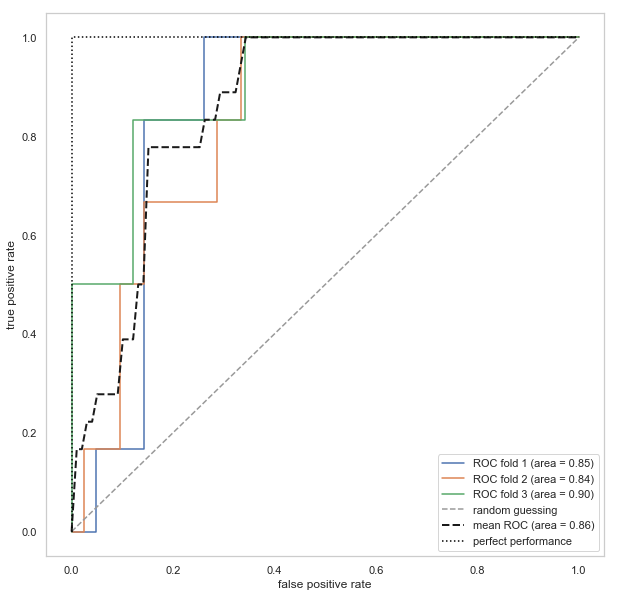

In [277]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([['sc', StandardScaler()], 
                 ['pca', PCA(n_components = 2)], 
                 ['clf', LogisticRegression(penalty ='l2', C = 0.0001, max_iter = 200)]
                    ])

cv = list(StratifiedKFold(n_splits=3, random_state=1).split(features, labels))

fig = plt.figure(figsize=(10,10))

mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)

# probas is the probability of each class, probas[:,1] is the probability of class 1
# Weights are updated after training sample in each fold
for i, (train, test) in enumerate(cv):
    probas = pipe.fit(np.array(features)[train,:], np.array(labels)[train]).predict_proba(np.array(features)[test,:])
    fpr, tpr, thresholds = roc_curve(np.array(labels)[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
plt.plot([0,1], [0,1], linestyle = '--', color=(0.6,0.6,0.6), label='random guessing')

# Average across all folds of CV
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label = 'mean ROC (area = %0.2f)' %mean_auc, lw=2)
plt.plot([0,0,1], [0,1,1], linestyle=':', color='black', label= 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.grid('off')
plt.show()
    

#### Hyperparameters chosen based on Precision

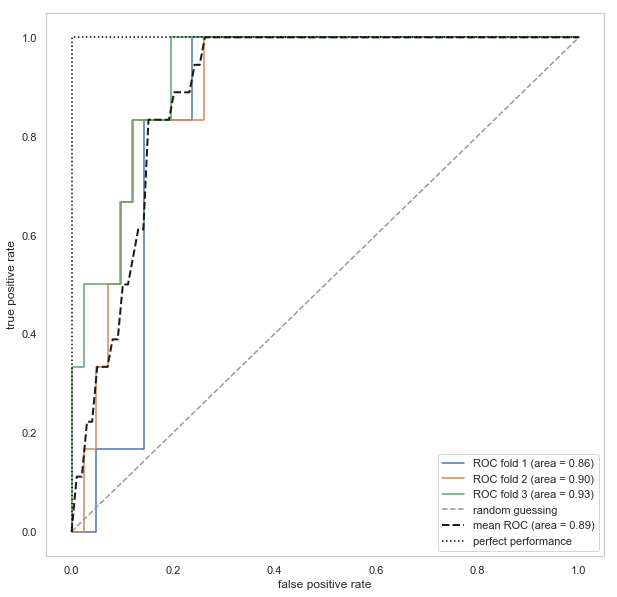

In [276]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([['sc', StandardScaler()], 
                 ['pca', PCA(n_components = 1)], 
                 ['clf', LogisticRegression(penalty ='l2', C = 0.01, max_iter = 200)]
                    ])

cv = list(StratifiedKFold(n_splits=3, random_state=1).split(features, labels))

fig = plt.figure(figsize=(10,10))

mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)


# probas is the probability of each class, probas[:,1] is the probability of class 1
for i, (train, test) in enumerate(cv):
    probas = pipe.fit(np.array(features)[train,:], np.array(labels)[train]).predict_proba(np.array(features)[test,:])
    fpr, tpr, thresholds = roc_curve(np.array(labels)[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
plt.plot([0,1], [0,1], linestyle = '--', color=(0.6,0.6,0.6), label='random guessing')

# Average across all folds of stratified CV
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label = 'mean ROC (area = %0.2f)' %mean_auc, lw=2)
plt.plot([0,0,1], [0,1,1], linestyle=':', color='black', label= 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.grid('off')
plt.show()
    

#### Precision-Recall Curve (Overall AUC using concatenate)

#### Hyperparameters chosen based on F1 and Recall

48 48
48 48
47 47


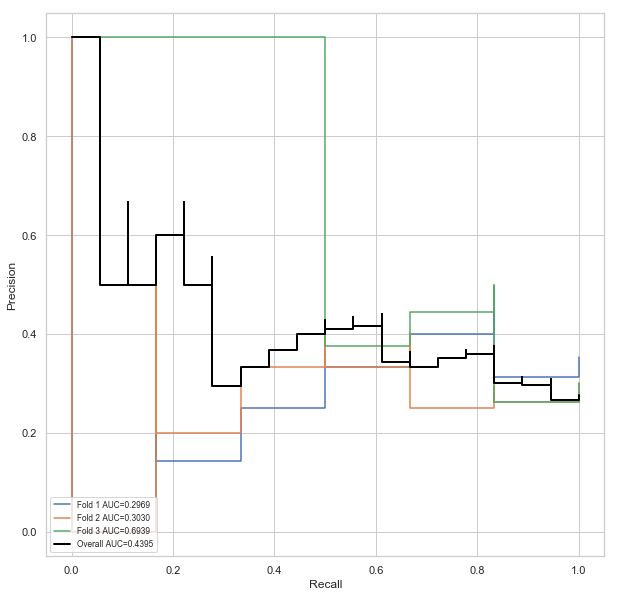

In [271]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([['sc', StandardScaler()], 
                 ['pca', PCA(n_components = 2)], 
                 ['clf', LogisticRegression(penalty ='l2', C = 0.0001, max_iter = 200)]
                    ])

cv = list(StratifiedKFold(n_splits=3, random_state=1).split(features, labels))

fig = plt.figure(figsize=(10,10))

y_real = []
y_proba = []

# probas is the probability of each class, probas[:,1] is the probability of class 1
for i, (train, test) in enumerate(cv):
    
    probas = pipe.fit(np.array(features)[train,:], np.array(labels)[train]).predict_proba(np.array(features)[test,:])
    precision, recall, thresholds = precision_recall_curve(np.array(labels)[test], probas[:,1], pos_label=1)
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    plt.step(recall, precision, label=lab)
    y_real.append(np.array(labels)[test])
    y_proba.append(probas[:,1])
    print(len(y_real[i]), len(y_proba[i]))

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)

precision, recall, thresholds = precision_recall_curve(y_real, y_proba, pos_label=1)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))
plt.step(recall, precision, label=lab, lw=2, color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize='small')
